# Data Generator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Data

In [3]:
CSV_FILE_PATH = "../data/preprocessed_data.csv"
MAX_RSSI = 0
MIN_RSSI = -99
DENOISE_SNR = 20

df = pd.read_csv(CSV_FILE_PATH)

### Preprocessing

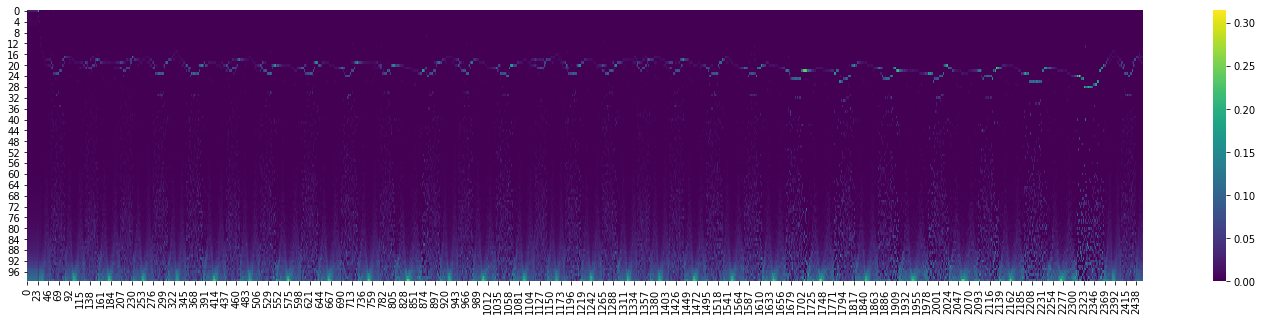

In [59]:
def prep_data(df):
    # extra training raws
    df_tx = df[df.tag == 'BP_WirelessTransmitter_C_1'][1:].reset_index(drop=True)
    # remove unused columns
    raw_df = df_tx.drop(columns=['tag', 'timestamp'])
    # split input and label columns
    input_df = raw_df.loc[:,f"{MAX_RSSI}":f"{MIN_RSSI}"].astype('float')
    label_df = raw_df[['x','y','z']]
    # convert input to pdf
    input_df = input_df.loc[:,f"{MAX_RSSI}":f"{MIN_RSSI}"].div(input_df.sum(axis=1), axis=0)
    
    plt.figure(figsize=(25,5))
    ax = sns.heatmap(input_df.loc[:,f"{MAX_RSSI}":f"{MIN_RSSI}"].to_numpy().transpose(1,0),cmap="viridis")
    plt.show()
    
    # concat label with input as new df
    new_df = pd.concat([label_df, input_df], axis=1)
    # get the diff of each rows
    diff_df = new_df.diff(axis=0)[1:]
    # normalize
    norm_df = (diff_df-diff_df.mean())/(diff_df.std() + 1e-10)
    
    # df_std = (df - train_mean) / train_std
#     df_std = norm_df.melt(var_name='Column', value_name='Normalized')
#     plt.figure(figsize=(25, 5))
#     ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
#     _ = ax.set_xticklabels(df.keys(), rotation=90)
#     plt.show()
    
    return norm_df, diff_df
norm_df, diff_df = prep_data(df)

In [5]:
from preprocess.data_generator import WindowSplitter

In [29]:
class DatasetGenerator(WindowSplitter):
    """
        Dataset Generator - generate time serise dataset
    """
    def __init__(self, data, input_width, label_width, shift,
                 columns, input_columns, label_columns, batch_size,
                 partition=(0.7, 0.2, 0.1), dtype='float32'):
        """
        :param data: the data before split，shape(seq_len, dim)
        :param input_width: input window size (input series size)
        :param label_width: label window size (label series size)
        :param shift: offset
        :param columns: list of column name
        :param input_columns: list of input feature column names
        :param label_columns: list of label feature column names
        :param batch_size: batch size
        :param partition: proportion of training/validation/testing dataset
        """
        super().__init__(input_width=input_width, label_width=label_width, shift=shift,
                         columns=columns, input_columns=input_columns, label_columns=label_columns)
        self.batch_size = batch_size
        self.partition = partition

        data = data.to_numpy().astype(dtype)

        self.full_ds = self.build_dataset(data)
        size = self.full_dataset_size();
   
        train_size = int(partition[0] * size)
        test_size  = int(partition[2] * size)
        
        self.train_ds = self.full_ds.take(train_size)
        self.test_ds = self.full_ds.skip(train_size)
        self.valid_ds = self.test_ds.skip(test_size)
        self.test_ds = self.test_ds.take(test_size)

    def build_dataset(self, data):
        """ Construct Dataset, split input data to training set/ validation set and test set

        Algorithm：
            1. call tensorflow api with batch_size=1 as the first time construct
            2. use map function，split each data point from dataset to input/label series
            3. then re-batch data set to desired size

        :param data: shape(seq_len, feature_dim)
        :return: batched dataset
        """
        # 1.
        dataset = timeseries_dataset_from_array(data=data, targets=None, sequence_length=self.total_window_size,
                                                sequence_stride=1, shuffle=True, batch_size=1)
        # check the size of dataset
        # print("dataset size before batch", dataset.cardinality().numpy())
        # 2.
        dataset = dataset.map(self)
        # 3.
        return dataset.unbatch().batch(self.batch_size)
    
    def full_dataset_size(self):
        count = 0
        for item in self.full_ds:
            count += 1
        return count

    def __repr__(self):
        return '\n'.join([
            f'<DatasetGenerator>',
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Input column name(s): {self.input_columns}',
            f'Label column name(s): {self.label_columns}',
            f'Batch size: {self.batch_size}',
            f'Partition: Train(%.2f), Validation(%.2f), Test(%.2f)' % self.partition,
        ])

In [30]:
columns = list(norm_df)

datagen = DatasetGenerator(data=norm_df,
                                     input_width=30,
                                     label_width=30,
                                     shift=1,
                                     columns=list(norm_df),
                                     input_columns=columns[3:],
                                     label_columns=columns[:3],
                                     batch_size=16,
                                     partition=(0.8, 0.1, 0.1))

In [31]:
print(datagen)

<DatasetGenerator>
Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Input column name(s): ['0', '-1', '-2', '-3', '-4', '-5', '-6', '-7', '-8', '-9', '-10', '-11', '-12', '-13', '-14', '-15', '-16', '-17', '-18', '-19', '-20', '-21', '-22', '-23', '-24', '-25', '-26', '-27', '-28', '-29', '-30', '-31', '-32', '-33', '-34', '-35', '-36', '-37', '-38', '-39', '-40', '-41', '-42', '-43', '-44', '-45', '-46', '-47', '-48', '-49', '-50', '-51', '-52', '-53', '-54', '-55', '-56', '-57', '-58', '-59', '-60', '-61', '-62', '-63', '-64', '-65', '-66', '-67', '-68', '-69', '-70', '-71', '-72', '-73', '-74', '-75', '-76', '-77', '-78', '-79', '-80', '-81', '-82', '-83', '-84', '-85', '-86', '-87', '-88', '-89', '-90', '-91', '-92', '-93', '-94', '-95', '-96', '-97', '-98', '-99']
Label column name(s): ['x', 'y'

## Test on Model

In [9]:
from nn.deepar import create_model
import time
import IPython
import IPython.display

In [10]:
model = create_model(dim_x=len(columns) - 3, dim_z=3)

In [11]:
EPOCHS = 10
results = {
    'train_loss':[],
    'train_rmse':[],
    'test_loss':[],
    'test_rmse':[]
}
train_result, test_result = {}, {}
train_ds = datagen.train_ds
test_ds = datagen.test_ds
for i in range(EPOCHS):
    start = time.time()
    for data in train_ds:
        train_result = model.train_step(data)
    for data in test_ds:
        test_result = model.test_step(data)
    template = 'Epoch {}, Loss: {:.5f}, RMSE {:.5f}, Test Loss: {:.5f}, Test RMSE {:.5f}, ETC {:.5f} secs'
    IPython.display.clear_output()
    print(template.format(i + 1,train_result['loss'], train_result['rmse'],test_result['loss'], test_result['rmse'],time.time() - start))
    results['train_loss'].append(train_result['loss'].numpy())
    results['train_rmse'].append(train_result['rmse'].numpy())
    results['test_loss'].append(train_result['loss'].numpy())
    results['test_rmse'].append(train_result['rmse'].numpy())

Epoch 10, Loss: 3.47597, RMSE 0.53749, Test Loss: 3.55476, Test RMSE 0.53702, ETC 14.97162 secs


In [51]:
def plot(datagen, example, model, plot_col, max_subplots=3, style='scatter'):
    inputs, labels = example
    plt.figure(figsize=(25, 8))
        
    plot_col_index = datagen.column_indices[plot_col]

    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')

        if datagen.label_columns:
            label_col_index = datagen.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        if label_col_index is None:
            continue
        
        labels_data = labels[n, :, label_col_index]
        if style == 'scatter':
            plt.scatter(datagen.label_indices, labels_data, edgecolors='k', label='Labels', c='#2ca02c', s=64)
        else:
            plt.plot(datagen.label_indices, labels_data, color='#2ca02c', linestyle='--', label='Labels')

            
        if model is not None:
            predictions = model(inputs)
            mu, sigma = predictions[0][n, :, label_col_index], predictions[1][n, :, label_col_index]
            
            if style == 'scatter': 
                plt.scatter(datagen.label_indices, mu, marker='X', edgecolors='k', label='Predictions',c='#ff7f0e', s=64)
            else:
                plt.plot(datagen.label_indices, mu, color='#ff7f0e', linestyle='-', label='Predictions')
                
            plt.fill_between(datagen.label_indices, (mu-3*sigma),(mu+3*sigma), color='b', alpha=.1)
        if n == 0:
            plt.legend()
        
        plt.xlabel('Time')

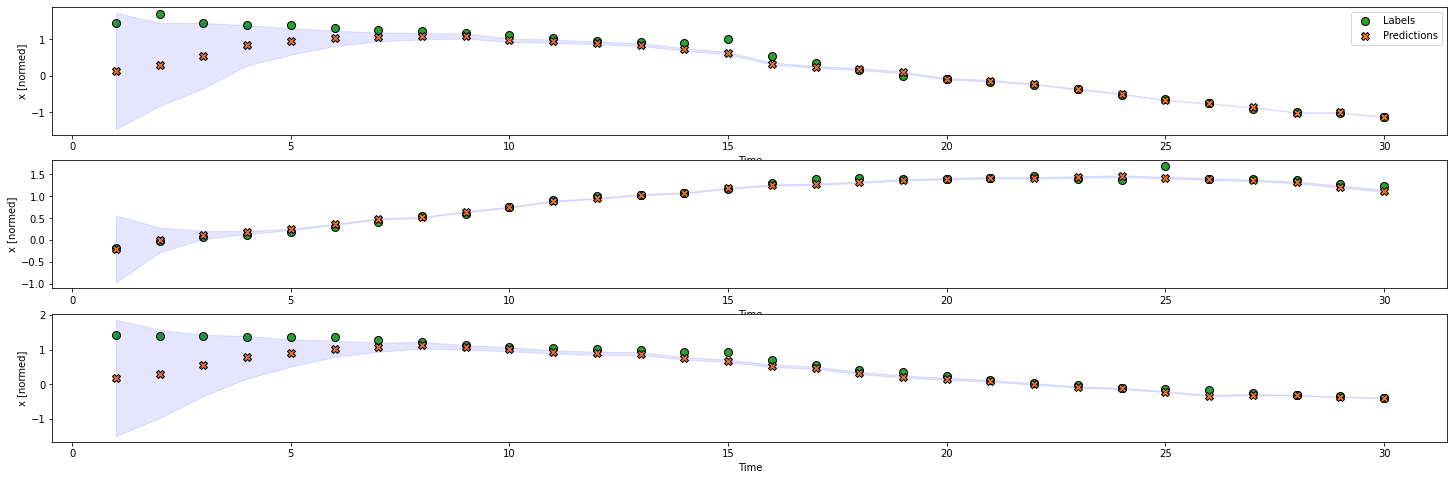

In [52]:
example = next(iter( datagen.test_ds))
plot(datagen, example,  model, 'x')

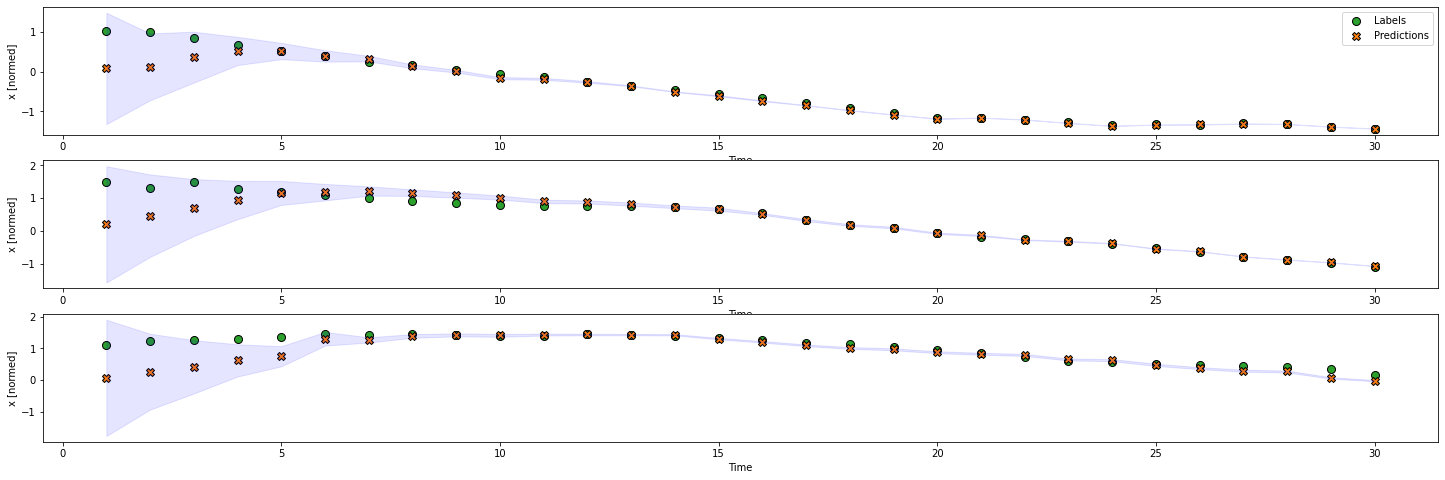

In [53]:
example = next(iter( datagen.valid_ds))
plot(datagen, example,  model, 'x')

### Test on full data

In [54]:
full_datagen = DatasetGenerator(data=norm_df,
                                input_width=1000,
                                label_width=1000,
                                shift=1,
                                columns=list(norm_df),
                                input_columns=columns[3:],
                                label_columns=columns[:3],
                                batch_size=1,
                                partition=(1, 0, 0))

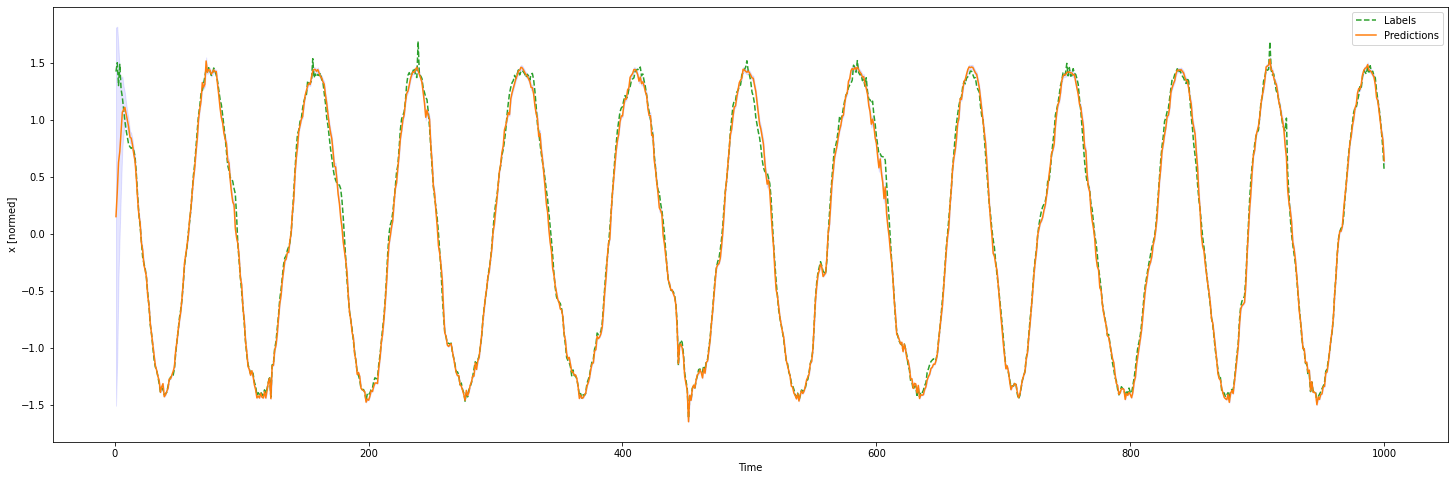

In [55]:
example = next(iter(full_datagen.train_ds))
plot(full_datagen, example, model, 'x', max_subplots=1, style='line')

## Plot data in 2D

In [75]:
def model_plot2D(model, data, batch_index, title='',warmup_step=10, df_mean=0, df_std=1, x_offset=0, y_offset=0):
    plt.figure(figsize=(20,10))
    inputs, labels = data
    means, _ = model(inputs)
    mean = (means[batch_index, :] * df_std + df_mean)
    label = (labels[batch_index, :] * df_std + df_mean)
    
    # as a velocity value we need to performance .cumsum(), to convert it back to the change of position
    plt.plot(mean[warmup_step:, 0].numpy().cumsum() + x_offset, mean[warmup_step:, 1].numpy().cumsum() + y_offset, '-r', alpha=0.5)
    plt.plot(label[warmup_step:,0].numpy().cumsum() + x_offset, label[warmup_step:,1].numpy().cumsum() + y_offset, '--g', alpha=0.5)
    plt.legend(labels=['Prediction', 'Ground Truth'], loc='lower left')
    plt.xlabel('X Coordinate (m)')
    plt.ylabel('Y Coordinate (m)')
    plt.title(title)
    plt.axis('equal')
    plt.show()

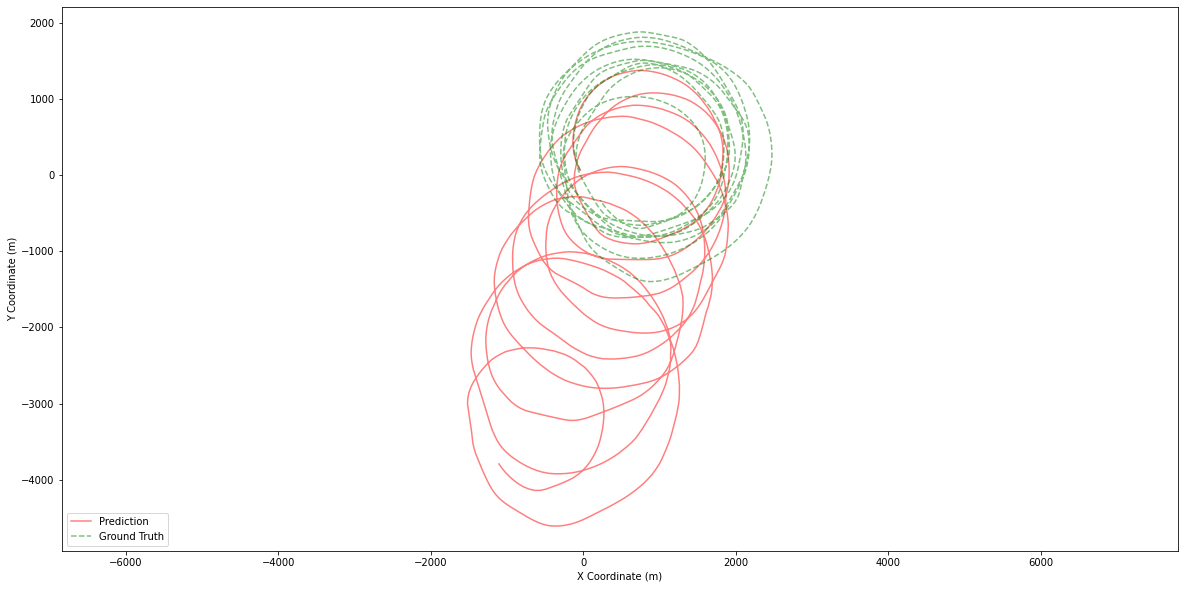

In [76]:
example = next(iter(full_datagen.train_ds))
model_plot2D(model, example, 0, df_mean=diff_df.mean()[:3], df_std=diff_df.std()[:3] + 1e-10) # [:3] is label columns x,y,z

In [70]:
np.array([1,2,3,4,5]).cumsum()

array([ 1,  3,  6, 10, 15], dtype=int32)